# Import Dataset, drop NaN's, select Proteins
This notebooks shows how to classify protein families soley based on their sequence of aminoacids. This work is based on the current success of deep learning models in natural language processing (NLP) and assumes the proteins sequences can be viewed as as a language. Please note, that there are notable search engines such as BLAST for this task.

Before we dive into, first some preprocessing of the data:
1. merge on *structureId*
2. drop rows without labels
3. drop rows without sequence
4. select proteins

In [1]:
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D,AveragePooling1D, Flatten,AtrousConvolution1D,SpatialDropout1D, Dropout, GlobalAveragePooling1D,GlobalMaxPooling1D
from keras.layers.normalization import BatchNormalization

from keras.layers import LSTM
from keras.layers.embeddings import Embedding

# https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
from keras.callbacks import EarlyStopping

from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:



# Merge the two Data set together
# Drop duplicates (unlike the original script)
df = pd.read_csv('../input/pdb_data_no_dups.csv').merge(pd.read_csv('../input/pdb_data_seq.csv'), how='inner', on='structureId').drop_duplicates(["sequence"]) # ,"classification"
# Drop rows with missing labels
df = df[[type(c) == type('') for c in df.classification.values]]
df = df[[type(c) == type('') for c in df.sequence.values]]
# select proteins
df = df[df.macromoleculeType_x == 'Protein']
df.reset_index()
print(df.shape)
df.head()

(87761, 18)


,structureId,classification,experimentalTechnique,macromoleculeType_x,residueCount_x,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear,chainId,sequence,residueCount_y,macromoleculeType_y
4,101M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,2.07,18112.80,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154,Protein
7,102L,HYDROLASE(O-GLYCOSYL),X-RAY DIFFRACTION,Protein,165,1.74,18926.61,NaN,NaN,2.75,55.28,NaN,NaN,1993.0,A,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...,165,Protein
8,102M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,1.84,18010.64,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154,Protein
11,103L,HYDROLASE(O-GLYCOSYL),X-RAY DIFFRACTION,Protein,167,1.90,19092.72,NaN,NaN,2.70,54.46,NaN,NaN,1993.0,A,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...,167,Protein
15,104L,HYDROLASE(O-GLYCOSYL),X-RAY DIFFRACTION,Protein,332,2.80,37541.04,NaN,NaN,3.04,59.49,NaN,NaN,1993.0,A,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSAA...,332,Protein


### remove some longer/shorter sequences
* the length is very skewed. We'll exclude some of the longer ones (many papers do <300-500 length sequences).
* For now we'l lleave the peptides (or potential fragments) in, i.e the very short (<30 AA) sequences

In [3]:
print(df.residueCount_x.quantile(0.9))
df.residueCount_x.describe()

1732.0


count     87761.000000
mean        922.913937
std        3173.118920
min           3.000000
25%         234.000000
50%         451.000000
75%         880.000000
max      157478.000000
Name: residueCount_x, dtype: float64

In [4]:
df = df.loc[df.residueCount_x<1200]
print(df.shape[0])
df.residueCount_x.describe()

73140


count    73140.000000
mean       433.599918
std        289.671609
min          3.000000
25%        198.000000
50%        373.000000
75%        618.000000
max       1198.000000
Name: residueCount_x, dtype: float64

# Preprocessing and visualization of dataset
**Ideally: **For comparison I also decided to focus only on those classes where the number of instances is greater than 1000 (as in [this kernel of Akil](https://www.kaggle.com/abharg16/predicting-protein-classification/code)) which corresponds to the 43 most common classes. 

**But:** one hour on 4 CPU is not sufficient for such big datasets, instead only 10 most common classes are considered.

at least 1416 instances per class
73140 instances before
37280 instances after


/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


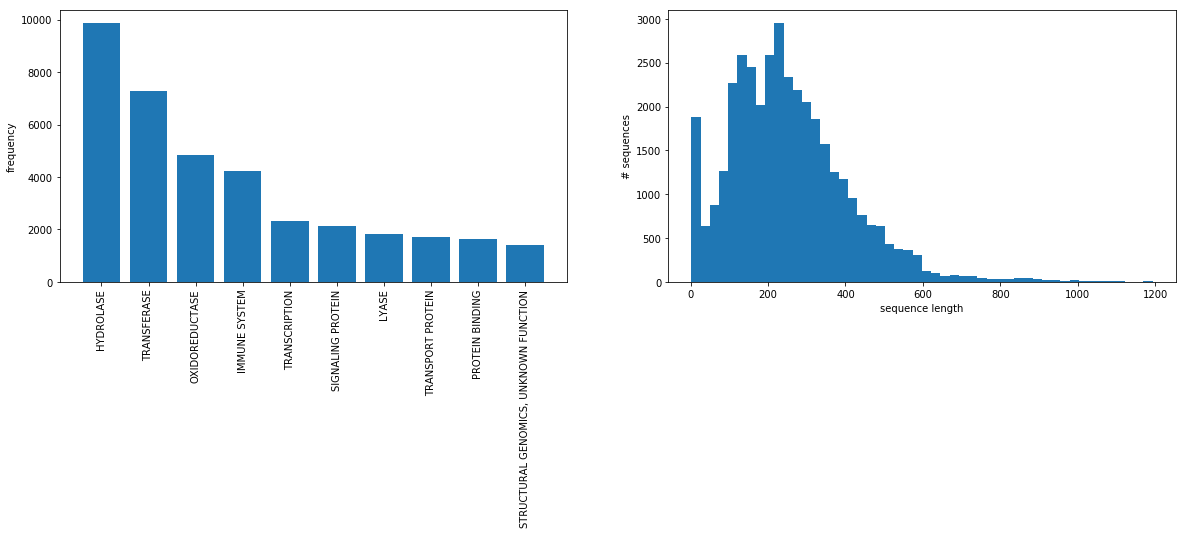

In [5]:
import matplotlib.pyplot as plt
from collections import Counter

# count numbers of instances per class
cnt = Counter(df.classification)
# select only K most common classes! - was 10 by default
top_classes = 10
# sort classes
sorted_classes = cnt.most_common()[:top_classes]
classes = [c[0] for c in sorted_classes]
counts = [c[1] for c in sorted_classes]
print("at least " + str(counts[-1]) + " instances per class")

# apply to dataframe
print(str(df.shape[0]) + " instances before")
df = df[[c in classes for c in df.classification]]
print(str(df.shape[0]) + " instances after")

seqs = df.sequence.values
lengths = [len(s) for s in seqs]

# visualize
fig, axarr = plt.subplots(1,2, figsize=(20,5))
axarr[0].bar(range(len(classes)), counts)
plt.sca(axarr[0])
plt.xticks(range(len(classes)), classes, rotation='vertical')
axarr[0].set_ylabel('frequency')

axarr[1].hist(lengths, bins=50, normed=False)
axarr[1].set_xlabel('sequence length')
axarr[1].set_ylabel('# sequences')
plt.show()

# Transform labels
First, the dataset is reduced to those samples wich are one of the ten most common classes. The length of sequences ranges from very few amino acids to several thousand amino acids (see plot below).

Second, using **LabelBinarizer** from **sklearn.preprocessing** transforms the labels in string to one hot representation.

In [6]:
from sklearn.preprocessing import LabelBinarizer

# Transform labels to one-hot
lb = LabelBinarizer()
Y = lb.fit_transform(df.classification)

# Further preprocessing of sequences with keras
Using the ** keras** library for text processing, 
1. ** Tokenizer**: translates every character of the sequence into a number
2. **pad_sequences:** ensures that every sequence has the same length (max_length). I decided to use a maximum length of 512, which should be sufficient for most sequences. **Note:** reduced to 256 for computational time reasons.
3. **train_test_split:** from sklearn splits the data into training and testing samples.

In [7]:

# maximum length of sequence, everything afterwards is discarded! Default 256
# max_length = 256
max_length = 350

#create and fit tokenizer
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(seqs)
#represent input data as word rank number sequences
X = tokenizer.texts_to_sequences(seqs)
X = sequence.pad_sequences(X, maxlen=max_length)

# Build keras model and fit
**Previous approaches:**

 [Kernel of hnike](https://www.kaggle.com/hnike25/best-machine-learning-model-on-the-dataset/code)  relied on numerical features of the data (with molecule weight, residue count etc.) 90% considering only the three most common classes. Without any claim of generality, some quick tests with this scenario showed superior results. 
 
[Kernel of abharg](https://www.kaggle.com/abharg16/predicting-protein-classification/code) used **CountVectorizer** from sklearn with 4-grams followed by a simple classification model and yielded accuaracy of about 76% considering the first 43 classes (classes where there are more than one thousand samples). Note that this approach is also based soley on the sequence and will be compared with my results.

## Further improvements
Now the most crucial part of this kernel:
1. recent success in NLP suggest to use word embeddings which is already implemented as a keras layer ([**Embedding**](https://keras.io/layers/embeddings/)). Note that in our case, there are only 20 different words (for each amino acid). Instead of word embedding, one could try a 2D convolution on the one hot representation of the sequence, but this approach focuses on applying NLP-theory to protein sequences. 
2. instead of using every n-gram, consider using [1D-convolution]() on the embedded sequences. The size of the convolutional kernel can be seen as size of n-grams and the number of filters as number of words. 
3. to improve performance also a deep architecture (subsequent layers of convolution and pooling) can be used, here two layers, where the first layer has 64 filters with convolutional size of 6 and the second layer has 32 filters of size 3.
4. Flatten and pass activations into fully connceted layers where the last layer is a softmax activation and size corresponding to the number of classes.

* Likely improvement: filter bank (instead of a linear chain of convolutions)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2)

In [9]:
embedding_dim = 25 # orig 8

# create the model
model = Sequential()
model.add(Embedding(len(tokenizer.word_index)+1, embedding_dim, input_length=max_length))
model.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='relu',dilation_rate=1))
# model.add(Conv1D(filters=64, kernel_size=6, padding='same', activation='relu')) #orig
model.add(Conv1D(filters=128, kernel_size=5, padding='valid', activation='relu',dilation_rate=1))
# model.add(BatchNormalization())
# model.add(MaxPooling1D(pool_size=2))
model.add(AveragePooling1D(pool_size=2))
# model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')) # orig
model.add(Conv1D(filters=128, kernel_size=7, padding='valid', activation='relu',dilation_rate=2)) 
model.add(BatchNormalization())
# model.add(MaxPooling1D(pool_size=2))
model.add(AveragePooling1D(pool_size=2))

# model.add(Flatten()) ## Could do pooling instead 
# GlobalAveragePooling1D,GlobalMaxPooling1D
model.add(GlobalAveragePooling1D())

model.add(Dense(256, activation='relu')) # 128
model.add(BatchNormalization())
model.add(Dense(128, activation='relu')) # 128
model.add(BatchNormalization())
model.add(Dense(top_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 350, 25)           650       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 350, 128)          12928     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 346, 128)          82048     
_________________________________________________________________
average_pooling1d_1 (Average (None, 173, 128)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 161, 128)          114816    
_________________________________________________________________
batch_normalization_1 (Batch (None, 161, 128)          512       
_________________________________________________________________
aver

In [10]:
es = EarlyStopping(monitor='val_acc', verbose=1, patience=3)

model.fit(X_train, y_train,  batch_size=128, verbose=1, validation_split=0.15,callbacks=[es],epochs=25) # epochs=15, # batch_size=128

Instructions for updating:
Use tf.cast instead.
Train on 25350 samples, validate on 4474 samples
Epoch 1/25
25350/25350 [==============================] - 222s 9ms/step - loss: 1.7797 - acc: 0.3812 - val_loss: 4.2638 - val_acc: 0.1339
Epoch 2/25
25350/25350 [==============================] - 217s 9ms/step - loss: 1.5912 - acc: 0.4387 - val_loss: 4.1349 - val_acc: 0.2642
Epoch 3/25
25350/25350 [==============================] - 215s 8ms/step - loss: 1.4843 - acc: 0.4809 - val_loss: 6.6693 - val_acc: 0.1120
Epoch 4/25
25350/25350 [==============================] - 214s 8ms/step - loss: 1.3845 - acc: 0.5265 - val_loss: 2.4593 - val_acc: 0.2841
Epoch 5/25
25350/25350 [==============================] - 214s 8ms/step - loss: 1.2831 - acc: 0.5696 - val_loss: 4.0113 - val_acc: 0.2767
Epoch 6/25
25350/25350 [==============================] - 214s 8ms/step - loss: 1.1832 - acc: 0.6080 - val_loss: 2.5612 - val_acc: 0.3637
Epoch 7/25
25350/25350 [==============================] - 213s 8ms/step - l

* Other Models
* http://nadbordrozd.github.io/blog/2017/08/12/looking-for-the-text-top-model/

In [11]:
from keras.layers import Conv1D, MaxPooling1D, Concatenate, Input
from keras.models import Sequential,Model

units = 256
num_filters = 32
filter_sizes=(3,5, 9,15,21)
conv_blocks = []

embedding_layer = Embedding(len(tokenizer.word_index)+1, embedding_dim, input_length=max_length)
es2 = EarlyStopping(monitor='val_acc', verbose=1, patience=4)

sequence_input = Input(shape=(max_length,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

z = Dropout(0.1)(embedded_sequences)

for sz in filter_sizes:
    conv = Conv1D(
        filters=num_filters,
        kernel_size=sz,
        padding="valid",
        activation="relu",
        strides=1)(z)
    conv = MaxPooling1D(pool_size=2)(conv)
    conv = Flatten()(conv)
    conv_blocks.append(conv)
z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
z = Dropout(0.25)(z)
z = BatchNormalization()(z)
z = Dense(units, activation="relu")(z)
z = BatchNormalization()(z)
predictions = Dense(top_classes, activation="softmax")(z)
model2 = Model(sequence_input, predictions)
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model2.summary())

model2.fit(X_train, y_train,  batch_size=64, verbose=1, validation_split=0.15,callbacks=[es],epochs=30)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 350)          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 350, 25)      650         input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 350, 25)      0           embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 348, 32)      2432        dropout_1[0][0]             

train-acc = 0.2650549892703863
test-acc = 0.24195278969957082


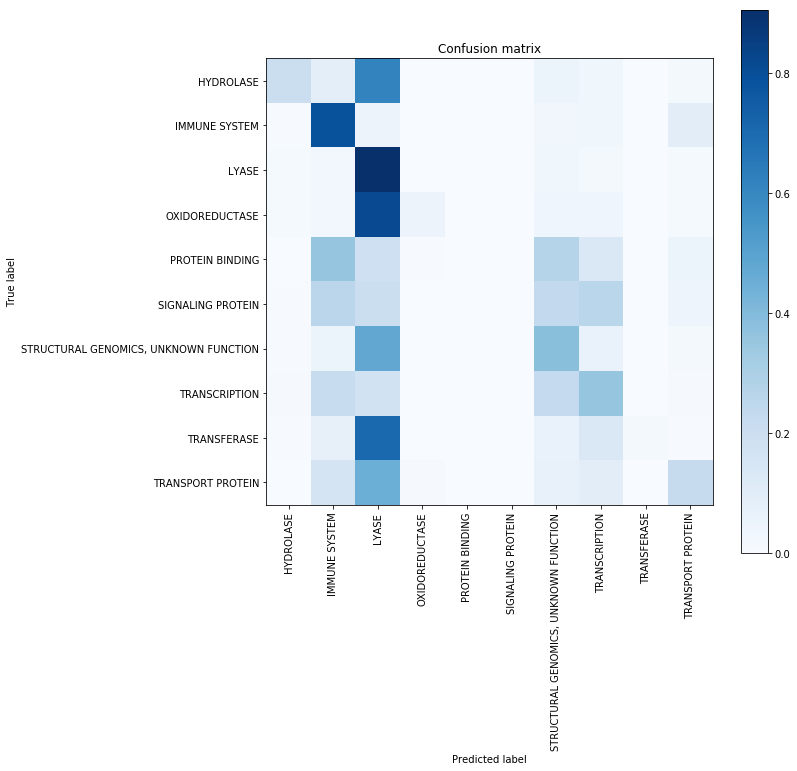

                                       precision    recall  f1-score   support

                            HYDROLASE       0.92      0.20      0.33      2040
                        IMMUNE SYSTEM       0.47      0.78      0.59       803
                                LYASE       0.09      0.90      0.16       377
                       OXIDOREDUCTASE       0.83      0.05      0.10       946
                      PROTEIN BINDING       0.00      0.00      0.00       320
                    SIGNALING PROTEIN       0.00      0.00      0.00       415
STRUCTURAL GENOMICS, UNKNOWN FUNCTION       0.16      0.38      0.22       276
                        TRANSCRIPTION       0.24      0.36      0.28       454
                          TRANSFERASE       0.94      0.02      0.04      1466
                    TRANSPORT PROTEIN       0.31      0.22      0.26       359

                            micro avg       0.24      0.24      0.24      7456
                            macro avg       0.39  

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [12]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import itertools

train_pred = model.predict(X_train)
test_pred = model.predict(X_test)
print("train-acc = " + str(accuracy_score(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1))))
print("test-acc = " + str(accuracy_score(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))))

# Compute confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))

# Plot normalized confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
np.set_printoptions(precision=2)
plt.figure(figsize=(10,10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(lb.classes_))
plt.xticks(tick_marks, lb.classes_, rotation=90)
plt.yticks(tick_marks, lb.classes_)
#for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#    plt.text(j, i, format(cm[i, j], '.2f'), horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2. else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print(classification_report(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1), target_names=lb.classes_))

train-acc = 0.9005498927038627
test-acc = 0.5953594420600858


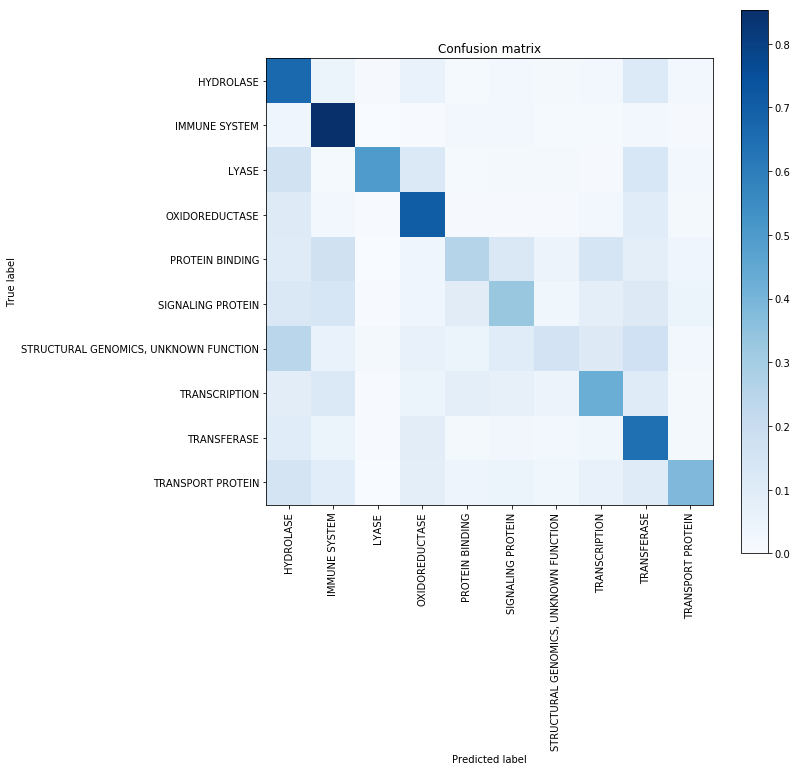

                                       precision    recall  f1-score   support

                            HYDROLASE       0.70      0.67      0.68      2040
                        IMMUNE SYSTEM       0.62      0.85      0.72       803
                                LYASE       0.83      0.50      0.62       377
                       OXIDOREDUCTASE       0.63      0.70      0.67       946
                      PROTEIN BINDING       0.31      0.26      0.28       320
                    SIGNALING PROTEIN       0.37      0.33      0.35       415
STRUCTURAL GENOMICS, UNKNOWN FUNCTION       0.23      0.16      0.18       276
                        TRANSCRIPTION       0.42      0.43      0.42       454
                          TRANSFERASE       0.61      0.65      0.63      1466
                    TRANSPORT PROTEIN       0.46      0.38      0.42       359

                            micro avg       0.60      0.60      0.60      7456
                            macro avg       0.52  

In [13]:
train_pred = model2.predict(X_train)
test_pred = model2.predict(X_test)
print("train-acc = " + str(accuracy_score(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1))))
print("test-acc = " + str(accuracy_score(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))))

# Compute confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))

# Plot normalized confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
np.set_printoptions(precision=2)
plt.figure(figsize=(10,10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(lb.classes_))
plt.xticks(tick_marks, lb.classes_, rotation=90)
plt.yticks(tick_marks, lb.classes_)
#for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#    plt.text(j, i, format(cm[i, j], '.2f'), horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2. else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print(classification_report(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1), target_names=lb.classes_))

Further improvements are possible (deeper model, smaller sequences, using n-grams as words for word embedding to accelerate learning) and should be validated via cross-validation. Could also be improved by Dropout, batchnorm, changing the architecture or regularizing by adding penalties for large weights (kernel_regularizer) or large activations (activation_regularizer). 